# Bitcoin Reddit Text Analytis 

#### 1. Data Collection and Overview
#### 2. Data Preprocessing
#### 3. Text Analytics 
- a. TF-IDF
- b. Word Cloud
- c. Named Entity Recognition (NER)
#### 4. Sentiment Analysis 
#### 5. Exploritory Data Analysis 
#### 6. Correlation Analysis 

-------------


### <h4><font color="yellow">Setting up the Enviornment</font></h4>


In [52]:
# Import base libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime

# Text Analytics Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS
import re
from nltk.corpus import stopwords
import nltk
from nltk import bigrams, trigrams 
from nltk import word_tokenize

# Setting up the enviornment location 
#path = 'P:/6. DSMA/99. Thesis/Python Stuff' # Windows Path
path = '/Users/erenmuller/pCloud Drive/6. DSMA/99. Thesis/Python Stuff'
os.chdir(path)

# Load in the dataset
btc = pd.read_csv('Data API Reddit/Master Data/BTC_R.csv')
btc = btc[['title','selftext', 'ups', 'date_posted']]
print('Dataset loaded')
print(btc.columns, btc.dtypes)

# Drop duplicates [not sure if good or not]
btc = btc.drop_duplicates()


Dataset loaded
Index(['title', 'selftext', 'ups', 'date_posted'], dtype='object') title           object
selftext        object
ups            float64
date_posted     object
dtype: object


### <h4><font color="yellow">Loading in the Dataset</font></h4>

- Only select Body, Upvotes, and Date Posted
- Transform the column to datetime 

In [ ]:
def parse_date(date_str):
    try:
        # Try parsing the ISO 8601 format
        return pd.to_datetime(date_str, utc=True)
    except ValueError:
        # Try parsing the 'dd/mm/yyyy hh:mm:ss AM/PM' format if the first attempt fails
        try:
            return pd.to_datetime(date_str, format='%d/%m/%Y %I:%M:%S %p', errors='coerce')
        except ValueError:
            # Return NaT if both formats fail
            return pd.NaT

def convert_dates(df, column_name):
    # Apply the parse_date function to the specified column
    df[column_name] = df[column_name].apply(parse_date)
    # Convert timezone-aware datetimes to naive UTC datetimes for uniformity
    df[column_name] = df[column_name].dt.tz_convert(None)
    return df


btc = convert_dates(btc, 'date_posted')
btc.tail(4)

### <h4><font color="yellow">Pre-Processing Text</font></h4>


In [55]:
# Blacklist of words 
blacklist = set(['https','com','nan','www','amp','png'])
#blacklist_2 = set(['bitcoin','btc'])


# MDS
# Ensure nltk resources are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+[a-z]\s+', ' ', text)
    text = re.sub(r'^[a-z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return ' '.join([word for word in text.split() if word not in stop_words and word not in blacklist])

# Apply preprocessing
btc['processed_title'] = btc['title'].apply(preprocess_text)
btc['processed_text'] = btc['selftext'].apply(preprocess_text)
btc.tail(4)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erenmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,selftext,ups,date_posted,processed_title,processed_text
8772,Jeff Booth's take on BTC,NaN,7.0,2024-05-05 22:19:25,jeff booth take btc,
8773,"100 BTC gold bar bought for $12,000, 11 years ...",NaN,2434.0,2024-05-04 13:17:11,100 btc gold bar bought 12 000 11 years ago 6 ...,
8774,Seen in Bamburg Germany,In English: Bitcoin Pioneer Bamburg. Have not ...,62.0,2024-05-05 08:10:55,seen bamburg germany,english bitcoin pioneer bamburg scanned qr cod...
8775,Scarcity Makes Everything Desirable (Including...,NaN,10.0,2024-05-05 17:39:42,scarcity makes everything desirable including ...,



### <h4><font color="yellow">Making TF-IDF</font></h4>


In [56]:
# Making TF-IDF
# Vectorization
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(btc['processed_text']).toarray()

# Convert to dataframe with the word names as well 
tfidf_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

# Sort the DataFrame columns by their sum in descending order
sorted_columns = tfidf_df.sum().sort_values(ascending=False).index
tfidf_df = tfidf_df[sorted_columns]
tfidf_df.head(5)


,bitcoin,btc,would,like,wallet,buy,people,money,know,get,...,key,org,google,resources,http,en,io,github,peer,wiki
0,0.635490,0.032775,0.027625,0.055077,0.08510,0.05315,0.022667,0.078470,0.000000,0.014401,...,0.056542,0.280425,0.14449,0.107243,0.383055,0.189677,0.178048,0.099873,0.116552,0.185352
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.755835,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.393499,0.177240,0.000000,0.000000,0.20918,0.00000,0.000000,0.212174,0.413531,0.194690,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



### <h4><font color="yellow">Making WordCloud</font></h4>


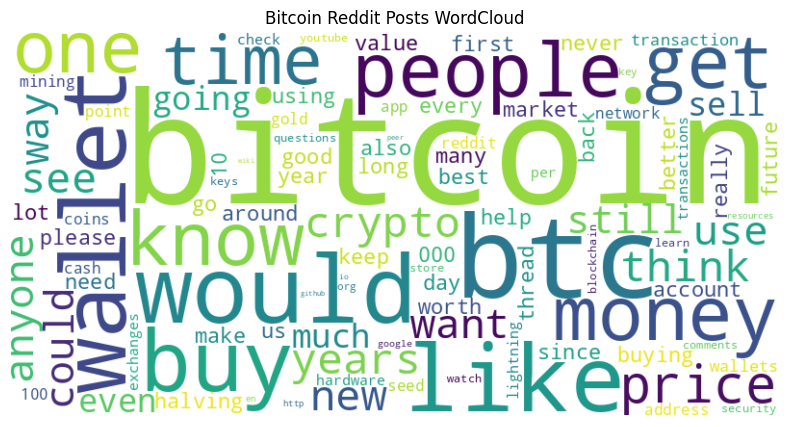

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sum TF-IDF scores for each word across all documents
word_scores = X.sum(axis=0)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary of word scores
word_scores_dict = dict(zip(feature_names, word_scores))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bitcoin Reddit Posts WordCloud')
plt.show()


### <h4><font color="yellow">Making NER Topics</font></h4>


In [40]:
import spacy
import pandas as pd

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Function to perform NER on text
def perform_ner(text):
    doc = nlp(text)
    # Extract named entities and their types
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER function to processed_text column
btc['ner_entities'] = btc['processed_text'].apply(perform_ner)

In [ ]:
# Function to count entity frequencies
def count_entity_frequencies(entities):
    entity_counts = {}
    for entity in entities:
        entity_name, entity_type = entity
        if entity_type not in entity_counts:
            entity_counts[entity_type] = {}
        if entity_name not in entity_counts[entity_type]:
            entity_counts[entity_type][entity_name] = 0
        entity_counts[entity_type][entity_name] += 1
    return entity_counts

# Apply function to ner_entities column
btc['entity_frequencies'] = btc['ner_entities'].apply(count_entity_frequencies)

# Concatenate dictionaries in entity_frequencies column
entity_counts = pd.concat([pd.DataFrame.from_dict(x, orient='index') for x in btc['entity_frequencies']], axis=1, sort=False)

# Fill NaN values with 0
entity_counts = entity_counts.fillna(0)

### <h4><font color="yellow">Making Bigrams and Trigrams</font></h4>


In [58]:
from nltk.util import ngrams
from collections import Counter


btc['processed_text'] = btc['processed_text'].fillna('').astype(str)


def generate_ngrams(text, n):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert to lower case
    # Generate n-grams
    return list(ngrams(words, n))

# Applying the function to each post and creating bigrams and trigrams
btc['bigrams'] = btc['processed_text'].apply(lambda x: generate_ngrams(x, 2))
btc['trigrams'] = btc['processed_text'].apply(lambda x: generate_ngrams(x, 3))

# Flatten the list of bigrams and trigrams and count occurrences
all_bigrams = [bigram for sublist in btc['bigrams'] for bigram in sublist]
bigram_counts = Counter(all_bigrams)
most_common_bigrams = bigram_counts.most_common(30)

all_trigrams = [trigram for sublist in btc['trigrams'] for trigram in sublist]
trigram_counts = Counter(all_trigrams)
most_common_trigrams = trigram_counts.most_common(30)

# Creating a DataFrame from the most common bigrams and trigrams
Grams = pd.DataFrame({
    'Bigram': [bigram for bigram, count in most_common_bigrams[:20]],
    'Trigram': [trigram for trigram, count in most_common_trigrams[:20]]
})

Grams

### Making PCA

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [1000] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot
[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


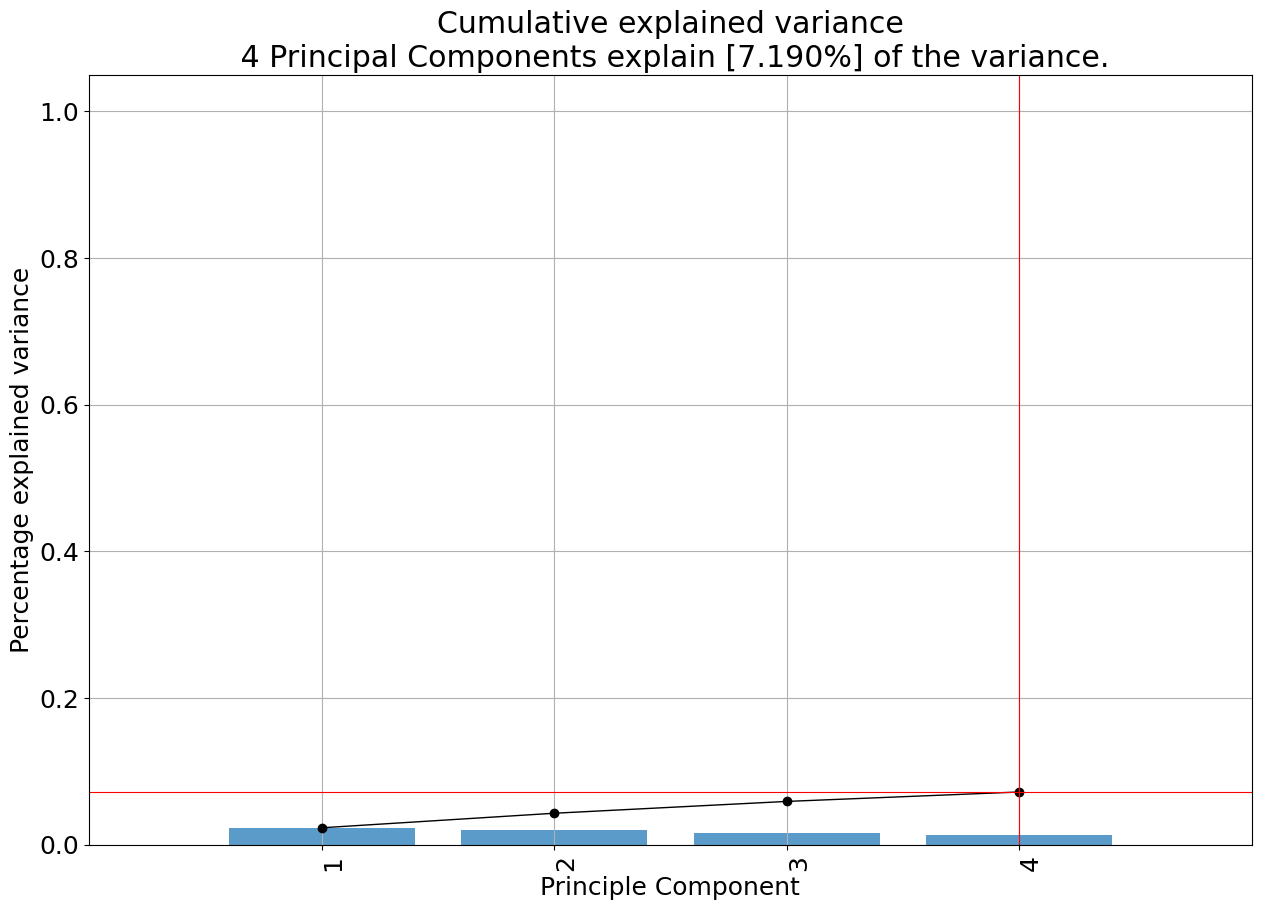

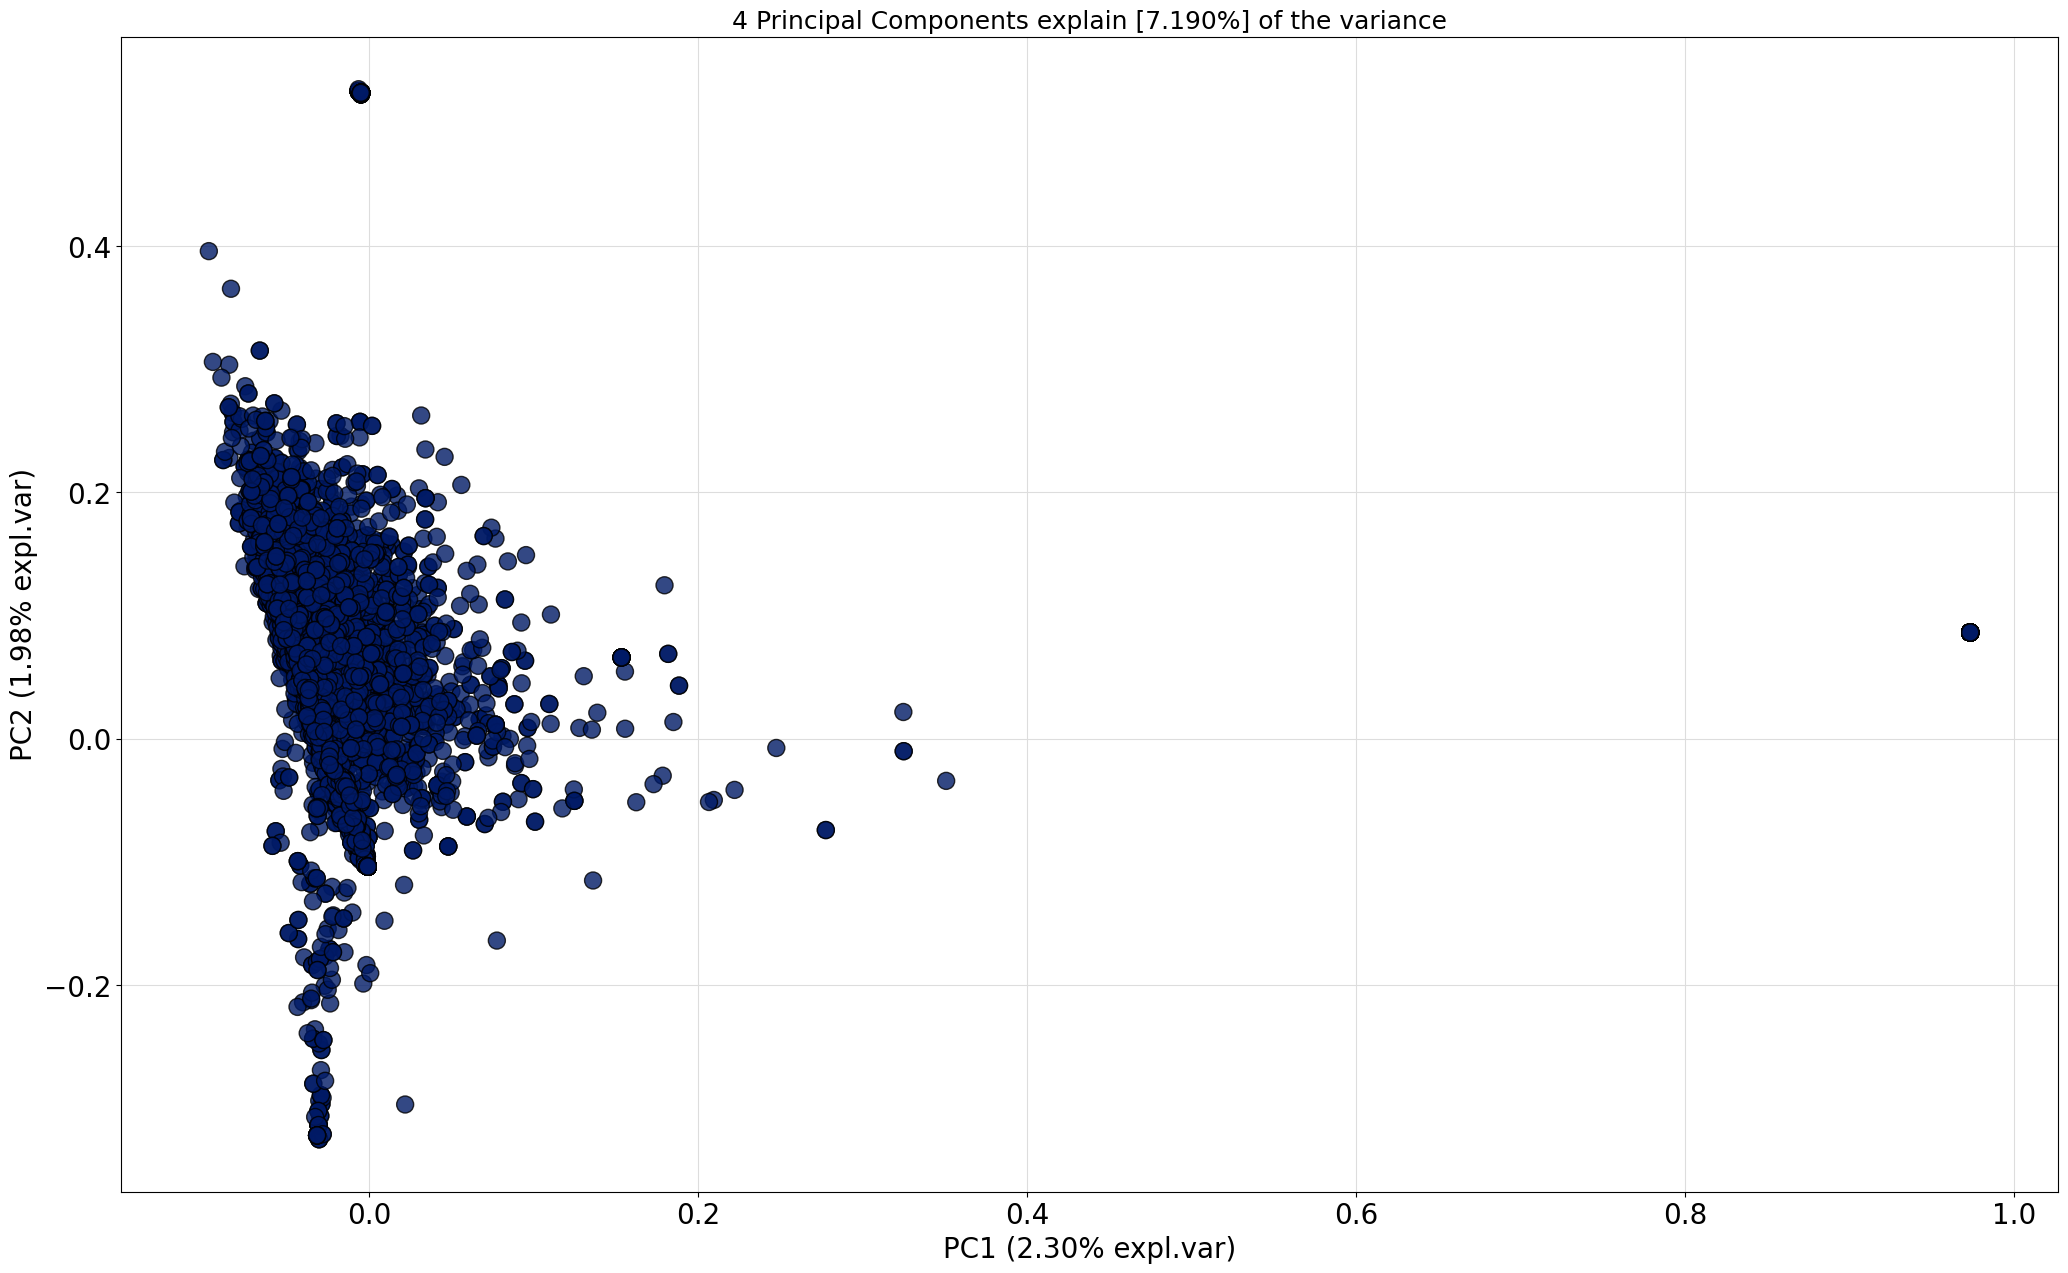

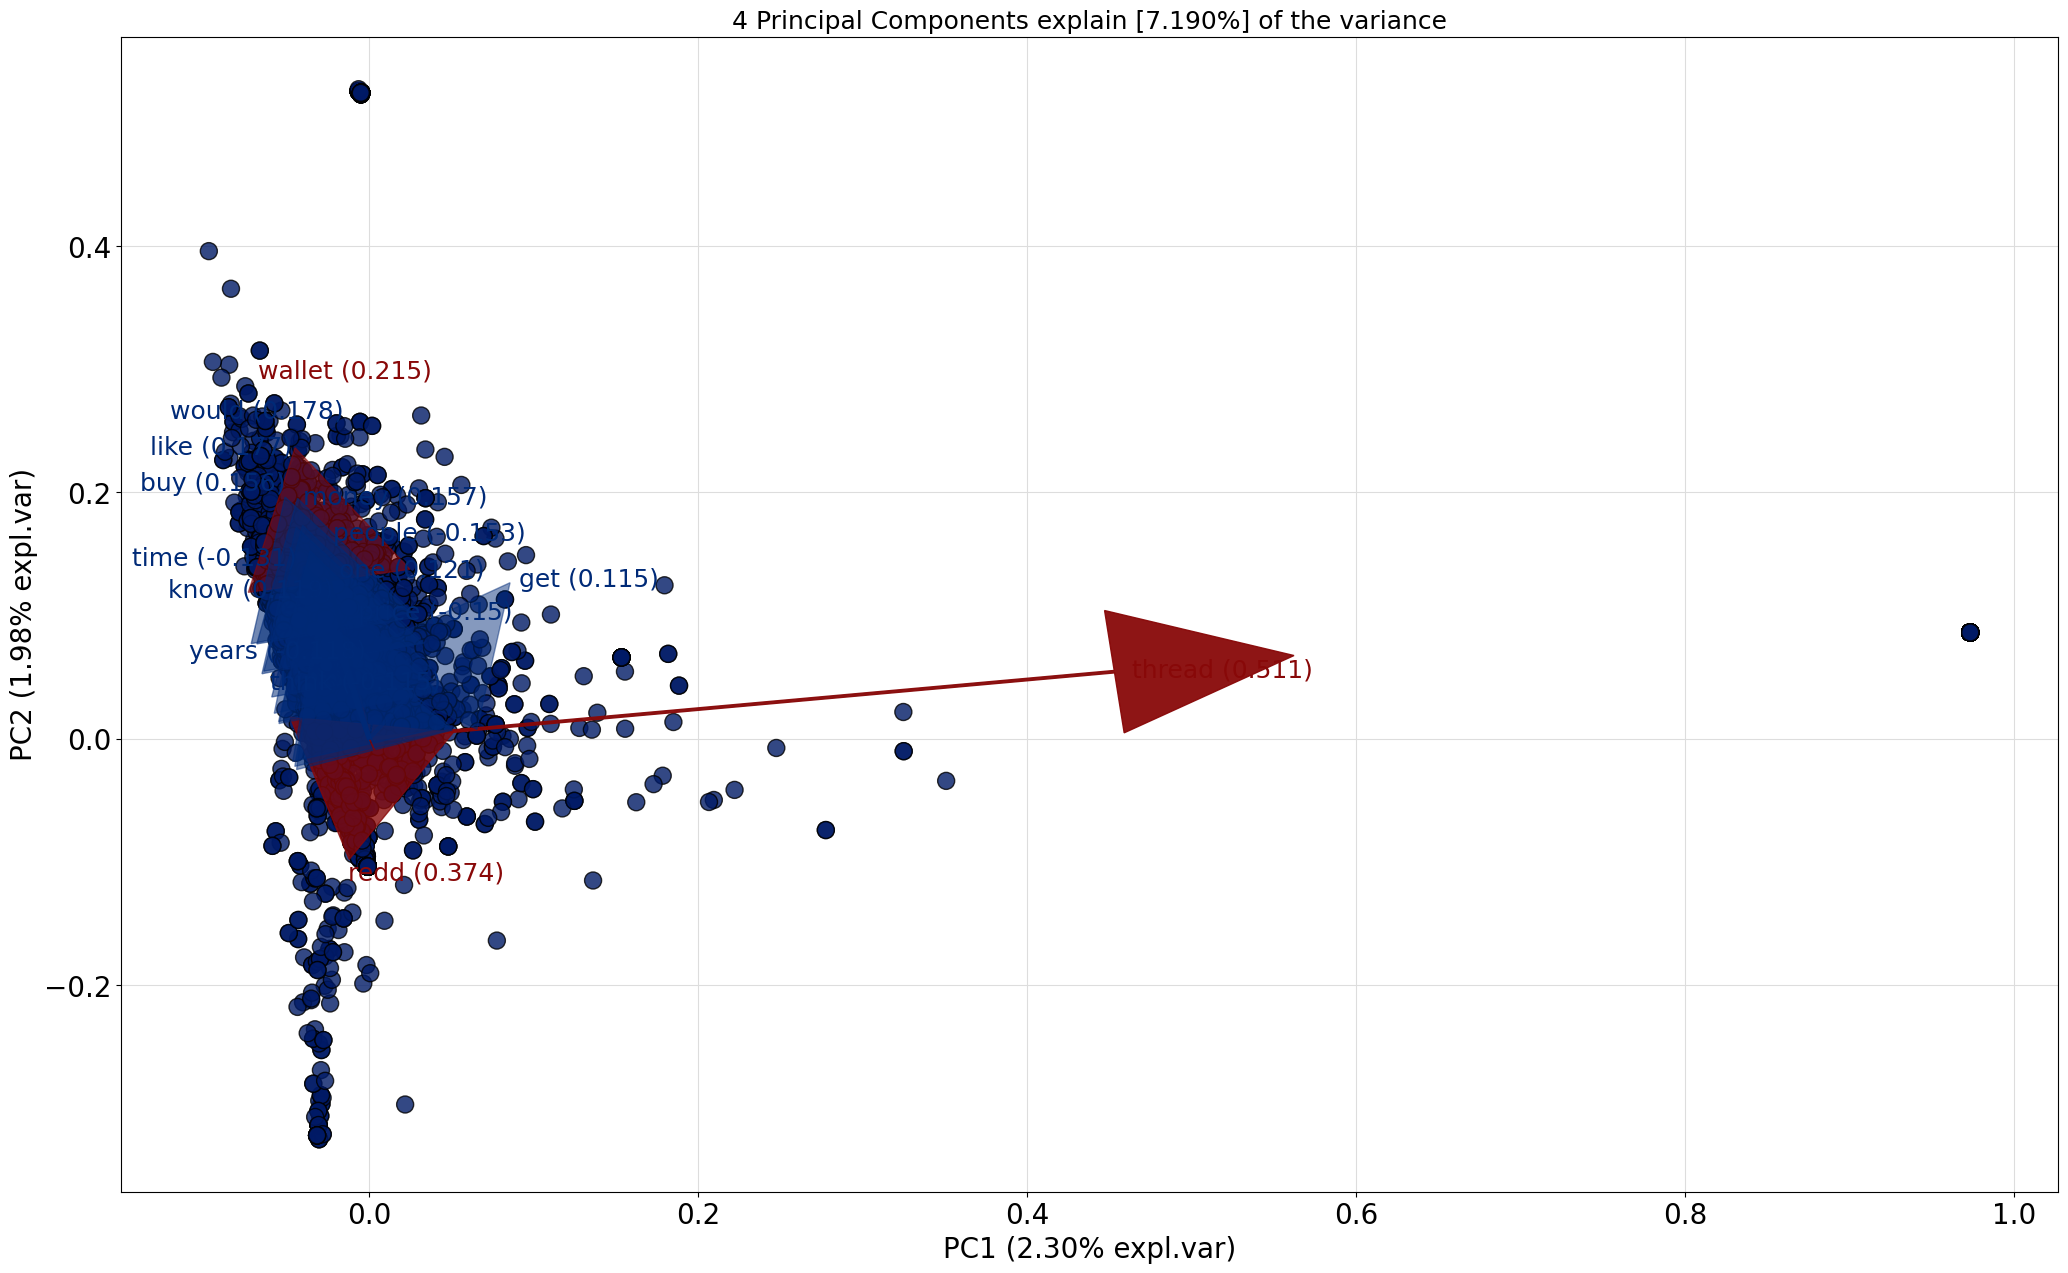

In [28]:
from pca import pca

model = pca(n_components=4)
results = model.fit_transform(X=tfidf_df)

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs 
fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot(n_feat=15)

In [69]:
results

{'loadings':        wallet     would      like       buy      know    people     money  \
 PC1 -0.046994 -0.052818 -0.046106 -0.046687 -0.036225 -0.037655 -0.041770   
 PC2  0.205068  0.177050  0.175473  0.159279  0.119687  0.136379  0.154329   
 PC3  0.042408  0.027874  0.039443  0.014348  0.010657  0.031933  0.039097   
 PC4  0.366826 -0.092997 -0.086776 -0.117784 -0.075668 -0.147562 -0.096423   
 
           one       get      time  ...  bitcoinwiki   porkbun   bitcore  \
 PC1 -0.035463  0.073295 -0.040676  ...    -0.000261 -0.000261 -0.000261   
 PC2  0.118749  0.118620  0.125698  ...     0.008810  0.008810  0.008810   
 PC3  0.031040  0.021021  0.030798  ...     0.004785  0.004785  0.004785   
 PC4 -0.016544 -0.075867 -0.127864  ...     0.015997  0.015997  0.015997   
 
      bitfortip   bitgigs   keybase    bitify  destinia  bitmarket  lectures  
 PC1  -0.000261 -0.000261 -0.000261 -0.000261 -0.000261  -0.000261 -0.000201  
 PC2   0.008810  0.008810  0.008810  0.008810  0.008810 

In [40]:
# MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X)



KeyboardInterrupt: 

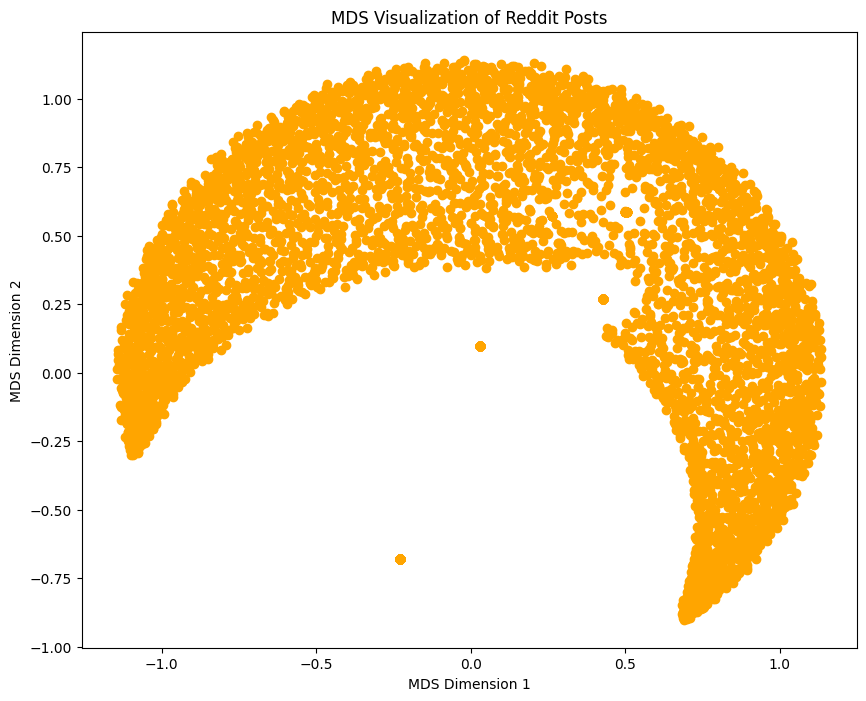

In [15]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c='orange', marker='o')
plt.title('MDS Visualization of Reddit Posts')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

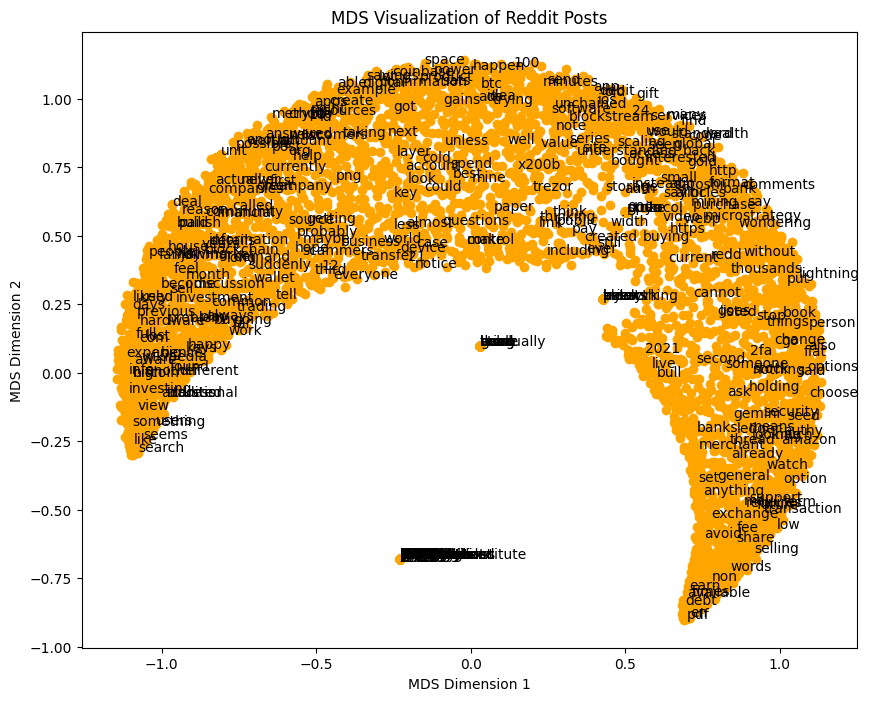

In [17]:
# Get feature names to use as labels (change this based on your specific requirements)
terms = vectorizer.get_feature_names_out()
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c='orange', marker='o')
for i, term in enumerate(terms):  # Loop through and add each term at its corresponding x,y point
    plt.annotate(term, (X_mds[i, 0], X_mds[i, 1]))
plt.title('MDS Visualization of Reddit Posts')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

In [22]:
X_mds[:, 0]#, X_mds[:, 1], c='orange', marker='o')


array([ 0.50551011, -0.52461766,  0.13831858, ..., -1.06499513,
       -0.9981225 , -1.09435837])

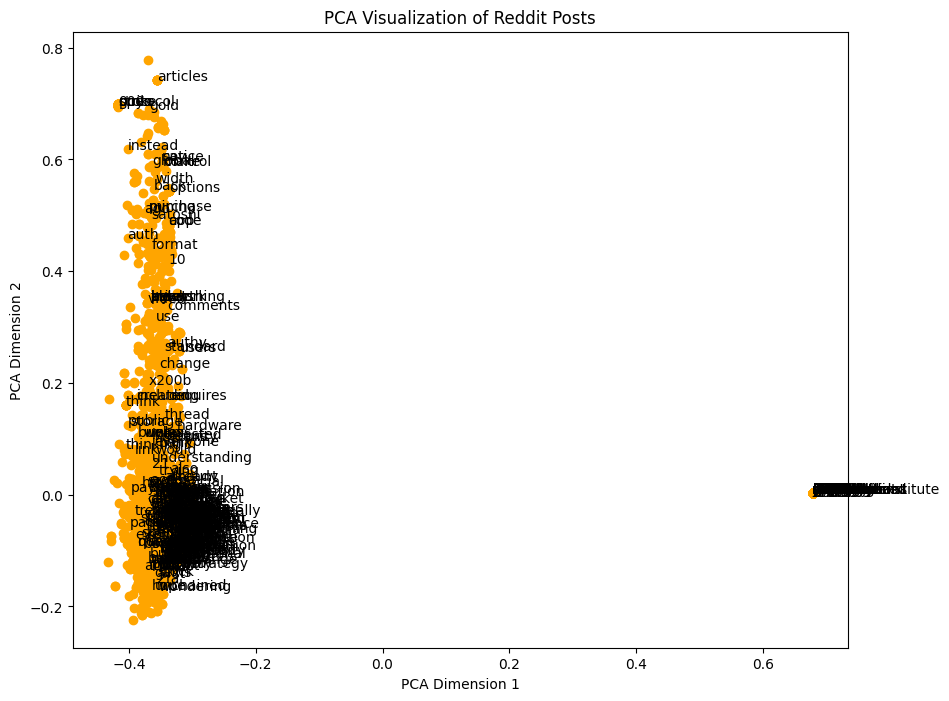

In [19]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='orange', marker='o')
for i, term in enumerate(terms):  # Annotate each point with its corresponding label
    plt.annotate(term, (X_pca[i, 0], X_pca[i, 1]))
plt.title('PCA Visualization of Reddit Posts')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

In [21]:
features = vectorizer.get_feature_names_out()

# Creating a DataFrame with the loadings
loadings = pca.components_.T  # Transpose to align the DataFrame properly (features as rows, PCs as columns)
df_loadings = pd.DataFrame(loadings, index=features, columns=['PC1', 'PC2'])

# Show the DataFrame
print(df_loadings)

              PC1       PC2
000     -0.011662  0.005585
10      -0.011134 -0.009023
100     -0.008246 -0.005799
12      -0.004107 -0.003349
15      -0.005070  0.002729
...           ...       ...
x200b   -0.011541  0.086360
year    -0.012298 -0.026042
years   -0.020098 -0.040333
yet     -0.006296 -0.010321
youtube -0.006146  0.065861

[500 rows x 2 columns]


In [26]:
import pandas as pd
from collections import defaultdict
import itertools

# Assuming 'btc' is your DataFrame and you've already loaded it.
# If there are missing values in the 'text' column, you can fill them with empty strings:
btc['processed_text'] = btc['selftext'].fillna('')  # Replace NaN with empty string

# Function to tokenize text and build a co-occurrence matrix
def build_cooccurrence_matrix(df, column, window_size=2):
    # Dictionary to hold word co-occurrences
    co_occurrences = defaultdict(int)

    # Tokenize and iterate over the DataFrame
    for text in df[column]:
        # Ensure the text is treated as a string
        words = str(text).lower().split()  # Convert to string and then tokenize
        for i in range(len(words)):
            # This token will be the center word
            token = words[i]
            # Collect tokens around the center word within the window size
            start = max(0, i-window_size)
            end = min(len(words), i+window_size+1)
            for j in range(start, end):
                if i != j:
                    pair = tuple(sorted([token, words[j]]))
                    co_occurrences[pair] += 1

    # Convert the dictionary to a DataFrame for easier manipulation
    co_matrix = pd.DataFrame(list(co_occurrences.items()), columns=['Word Pair', 'Frequency'])

    co_matrix = co_matrix.sort_values(by='Frequency', ascending=False)
    return co_matrix

# Build the co-occurrence matrix
co_matrix = build_cooccurrence_matrix(btc, 'selftext', window_size=2)

print(co_matrix)

# Save the DataFrame to a text file
co_matrix.to_csv('co_matrix.txt', sep='\t', index=False)

print("Co-occurrence matrix saved to 'co_matrix.txt'.")


             Word Pair  Frequency
105          (of, the)       6612
4            (the, to)       5002
90           (in, the)       3832
70           (if, you)       3792
1337        (and, the)       3310
...                ...        ...
37283     (a, farmers)          2
37285   (few, running)          2
86270       (0.52, is)          2
86269      (0.52, btc)          2
302363    (mark, post)          2

[302364 rows x 2 columns]
Co-occurrence matrix saved to 'co_matrix.txt'.


In [29]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

Word2Vec

In [36]:
# Ensure all entries are strings (convert NaNs and other non-string entries to empty strings)
sentences = [str(s) for s in btc.selftext]

# Train a Word2Vec model
model = Word2Vec(sentences=[s.split() for s in sentences], vector_size=100, window=5, min_count=1, workers=12)

# Extract the words & their vectors
words = list(model.wv.index_to_key)
word_vectors = np.array([model.wv[word] for word in words])

In [37]:
# Use t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=0)
word_vecs_2d = tsne.fit_transform(word_vectors)

In [42]:
word_vecs_2d

array([[ 90.29171  ,   5.842869 ],
       [ 95.82843  ,   7.5718684],
       [ 95.42     ,   6.689143 ],
       ...,
       [  9.123021 , -24.004904 ],
       [-22.755096 ,  35.259686 ],
       [-53.497368 ,  -6.5249534]], dtype=float32)

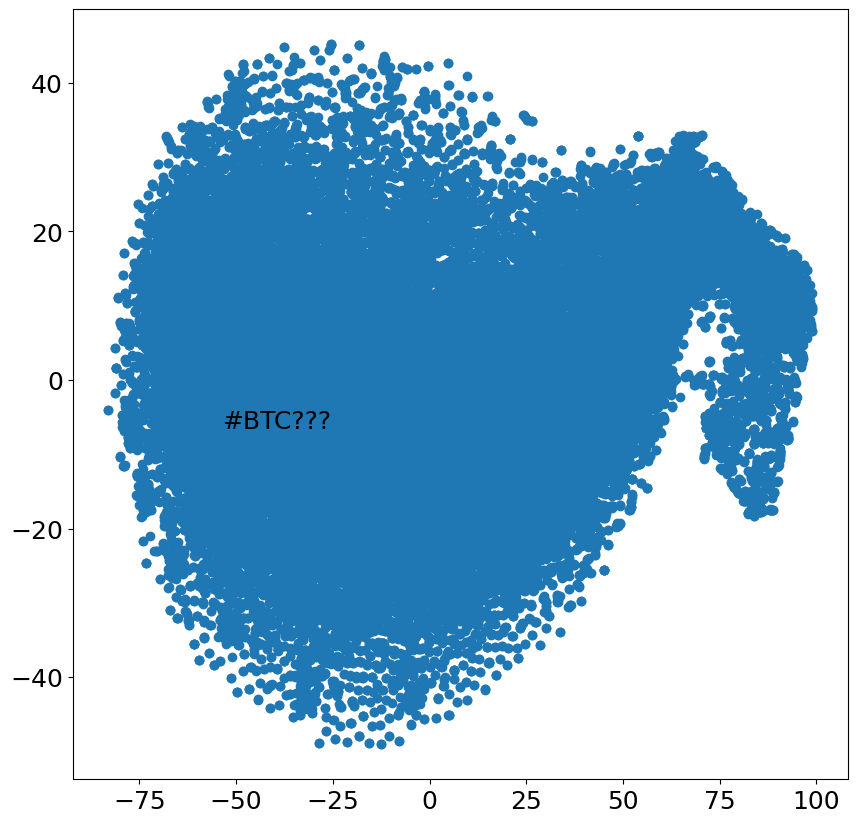

In [43]:
# Plot the results
plt.figure(figsize=(10, 10))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1])
plt.text(x, y, word)
plt.show()